# PROJECT: 한국어 데이터로 챗봇 만들기
---

<br>

## 개요
앞 선 예제에서 구현했던 '영어 데이터로 대화형 챗봇 만들기'를 참고하여 한국어 데이터를 사용하는 챗봇을 만들어본다.  

## 목차
1. 필요한 라이브러리 불러오기
2. 데이터 수집하기
3. 데이터 전처리하기
4. SubwordTextEncoder 사용하기
5. 모델 구성하기
6. 모델 평가하기

### STEP 1. 필요한 라이브러리 불러오기
---
프로젝트 진행에 필요한 라이브러리를 import하고, 주요 라이브러리의 버전을 확인한다.

In [1]:
# 데이터 경로 접근을 위한 시스템 라이브러리
import os
# 연산을 위한 라이브러리
import numpy as np
# csv 파일 처리을 위한 라이브러리
import pandas as pd
# 데이터 전처리를 위한 라이브러리
import re

# 텐서 관리를 위한 라이브러리
import tensorflow as tf
# 단어장 생성을 위한 라이브러리
import tensorflow_datasets as tfds
# 모델 설계를 위한 라이브러리와 모듈들
from tensorflow.keras import Input, Model, utils
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Embedding, Lambda
# 마스킹 처리를 위한 모듈
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 손실함수 지정을 위한 모듈
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# 학습률 지정을 위한 모듈
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
# 옵티마이저 지정을 위한 모듈
from tensorflow.keras.optimizers import Adam
# 평가지표 지정을 위한 모듈
from tensorflow.keras.metrics import sparse_categorical_accuracy

# 출력 결과 시각화를 위한 모듈
import matplotlib.pyplot as plt

print('Version of Tensorflow: {}'.format(tf.__version__))

Version of Tensorflow: 2.6.0


지금은 각 과정에서 어떤 라이브러리와 모듈을 사용하는지 파악하기 위해 한 번에 import를 했지만, 위와 같은 방법을 사용할 경우 향후 작성될 코드에서 어떤 라이브러리를 사용하는지 파악하기 어렵기 때문에 from ~ import는 지양하는 것이 좋다고 한다.

### STEP 2. 데이터 수집하기
---
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용한다.  
이 데이터는 아래의 링크에서 다운로드할 수 있다.  
* [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)  

`Cloud shell`에서 아래 명령어를 입력하여 디렉터리를 생성하고 데이터를 추가한다.  
```
$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ cp ~/data/* ~/aiffel/transformer_chatbot/data/
```

### STEP 3. 데이터 전처리하기
---
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만, 전체적으로는 다른 전처리를 수행해야 할 수도 있다.

In [2]:
# csv 파일 경로 접근
dirpath = os.getenv('HOME') + '/aiffel/transformer_chatbot/data'
# csv 파일 접근
filepath = os.path.join(dirpath, 'ChatbotData .csv')
filepath

'/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv'

In [3]:
# 데이터 읽기
raw_data = pd.read_csv(filepath)

# 상위 5개의 데이터 확인
raw_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
# 데이터 개수 확인
len(raw_data)

11823

데이터가 그렇게 많지는 않으니, 전체 샘플을 사용하도록 하겠다.

In [5]:
# 데이터 전처리 함수 정의
def preprocess_sentence(sentence):
    # 영어는 소문자로 변환하고 양쪽 공백 제거
    sentence = sentence.lower().strip()
    
    # 마지막 단어와 !, ?, . 사이의 공백 추가
    sentence = re.sub(r'([?.!,])', r' \1 ', sentence)
    sentence = re.sub(r'[" "]+', ' ', sentence)
    
    # 한글, 영문, !, ?, ., ,를 제외한 문자는 공백으로 변환
    sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z.?!,\s]', ' ', sentence)
    # 양쪽 공백 제거
    sentence = sentence.strip()
    
    return sentence

preprocess_sentence 함수의 동작 원리는 다음과 같다.
* 양쪽 공백 제거
> ex)[  눈살이 찌푸려지죠.  ] -> [눈살이 찌푸려지죠.]  
* 마지막 단어와 구두점 사이의 공백 추가
> ex)[눈살이 찌푸려지죠.] -> [눈살이 찌푸려지죠 .]  
* 한글, 영문, 구두점과 쉼표를 제외한 문자는 공백으로 변환
> ex) [눈살이 찌푸려지죠 .] -> [눈살이 찌푸려지죠 .]  
* 공백 제거
> ex) [눈살이 찌푸려지죠 .] -> [눈살이 찌푸려지죠.]

In [6]:
# 데이터 전처리 함수 적용
preprocessed_questions = [preprocess_sentence(sentence) for sentence in raw_data['Q']]
preprocessed_answers = [preprocess_sentence(sentence) for sentence in raw_data['A']]

# 전처리된 데이터 확인
for i in range(5):
    print(f"Original Question: {raw_data['Q'][i]}")
    print(f"Preprocessed Question: {preprocessed_questions[i]}")
    print(f"Original Answer: {raw_data['A'][i]}")
    print(f"Preprocessed Answer: {preprocessed_answers[i]}\n")

Original Question: 12시 땡!
Preprocessed Question: 시 땡 !
Original Answer: 하루가 또 가네요.
Preprocessed Answer: 하루가 또 가네요 .

Original Question: 1지망 학교 떨어졌어
Preprocessed Question: 지망 학교 떨어졌어
Original Answer: 위로해 드립니다.
Preprocessed Answer: 위로해 드립니다 .

Original Question: 3박4일 놀러가고 싶다
Preprocessed Question: 박 일 놀러가고 싶다
Original Answer: 여행은 언제나 좋죠.
Preprocessed Answer: 여행은 언제나 좋죠 .

Original Question: 3박4일 정도 놀러가고 싶다
Preprocessed Question: 박 일 정도 놀러가고 싶다
Original Answer: 여행은 언제나 좋죠.
Preprocessed Answer: 여행은 언제나 좋죠 .

Original Question: PPL 심하네
Preprocessed Question: ppl 심하네
Original Answer: 눈살이 찌푸려지죠.
Preprocessed Answer: 눈살이 찌푸려지죠 .



정규표현식이 정상적으로 적용된 것을 확인할 수 있다.

In [7]:
# 전체 샘플 개수 확인
print('전체 샘플 수: ', len(preprocessed_questions))
print('전체 샘플 수: ', len(preprocessed_answers))

전체 샘플 수:  11823
전체 샘플 수:  11823


### STEP 4. SubwordTextEncoder 사용하기
---
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분들이 알고 있다. 하지만 이 번 프로젝트에서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 `SubwordTextEncoder`를 그대로 사용해보도록 한다.

In [8]:
# 토크나이저 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(preprocessed_questions + preprocessed_answers, target_vocab_size=2**13)

print('Done!')

Done!


In [9]:
# 시작 토큰과 종료 토근 지정
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 생성된 시작토큰과 종료 토큰 확인
print('START_TOKEN의 번호: ', [tokenizer.vocab_size])
print('END_TOKEN의 번호: ', [tokenizer.vocab_size + 1])

START_TOKEN의 번호:  [8146]
END_TOKEN의 번호:  [8147]


In [10]:
# 단어장 크기 지정
VOCAB_SIZE = tokenizer.vocab_size + 2

# 단어장 크기 확인
print(VOCAB_SIZE)

8148


In [11]:
# 정수 인코딩 후의 샘플 확인
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(preprocessed_questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(preprocessed_answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5756, 613, 2495, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2361, 7495, 7, 6262, 98, 1]


In [12]:
# 샘플 최대 길이 지정
MAX_LENGTH = 40

print(MAX_LENGTH)

40


In [13]:
# 토크나이징 및 정수 인코딩 함수 정의
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [14]:
questions, answers = tokenize_and_filter(preprocessed_questions, preprocessed_answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8148
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [15]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하여 **교사 강요** 훈련 기법을 사용한다.

### STEP 5. 모델 구성하기
---
앞 서 진행했던 실습 내용을 바탕으로 transformer 모델을 설계한다.

In [16]:
# 포지셔널 인코딩 레이어 구현
class PositionalEncoding(Layer):
    
    # 생성자 정의
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    # Positional Encoding에서 사용할 각도 배열을 생성하는 메서드 정의
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    # Positional Encoding을 계산하는 메서드 정의
    def positional_encoding(self, position, d_model):
        # 각 위치(position)과 차원(d_model)에 대한 각도 배열 생성
        angle_rads = self.get_angles(
            position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model = d_model
        )
        
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 교차하도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        # 배치 차원 추가
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)
    
    # Positional Encoding을 입력에 더하여 반환하는 메서드
    def call(self, inputs):
        # 입력의 형태를 기반으로 Positional Encoding의 일부를 잘라내어 사용
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

$$PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}})$$  
각 임베딩 벡터에 대해 해당 단어의 순서 정보를 더할 수 있도록, 위와 같은 연산을 수행하는 Positional Encoding함수를 정의한다.

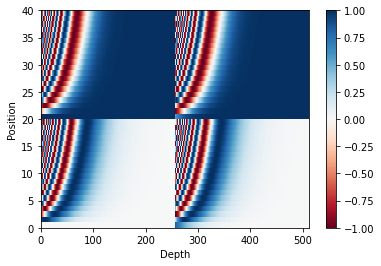

In [17]:
# PositioalEncoding 샘플 확인
sample_pos_encoding = PositionalEncoding(40, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

미리 설정한 최대 문장 길이인 40의 값과 512차원에 대한 샘플 positional encoding 값을 확인할 수 있다.  
사실 위의 그래프에 대해서는 여러 자료를 찾아봤는데도 어떻게 해석을 해야할지 감이 안잡혀서 추후에 수식에 따른 시각화를 진행하여 비교분석을 해야할 것 같다.

In [18]:
# 스케일드 닷 프로덕트 어텐션 레이어 구현
def scaled_dot_product_attention(query, key, value, mask):
    # query와 key의 행렬 곱셈 계산
    matmul_qk = tf.matmul(query, key, transpose_b = True)
    # key의 마지막 차원 크기(d_k)를 float32 타입으로 변환
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    # 스케일링을 위해 matmul_qk를 depth의 제곱근으로 나눔
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # mask가 비어있지 않을 때, masked softmax 계산을 위해 logits에 mask 값을 더함
    if mask is not None:
        # mask가 0인 위치에 매우 작은 값을 더해줌
        logits += (mask * -1e9)
        
    # softmax 함수를 적용하여 attention weights 계산
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # attention weights와 value의 행렬 곱셈을 통해 최종 output 계산
    output = tf.matmul(attention_weights, value)
    
    return output

단어 간의 유사도(벡터 간의 내적값)를 연산하고 그 값을 정규화시키는 `scaled_dot_product_attention`함수를 정의하여 어텐션을 구현한다.  
스케일드 닷 프로덕트 어텐션의 수식은 다음과 같다.  
$$Attention(Q, K, V) = softmax({{QK^T}\over {\sqrt {d_k}}})V$$

In [19]:
# 멀티 헤드 어텐션 레이어 구현
class MultiHeadAttention(Layer):
    # 생성자 메서드 정의
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        # d_model이 num_heads로 나누어 떨어지는지 확인
        assert d_model % self.num_heads == 0
        
        # 각 헤드의 차원 계산
        self.depth = d_model // self.num_heads
        
        # query, key, value에 대한 Dense 레이어 생성
        self.query_dense = Dense(units=d_model)
        self.key_dense = Dense(units=d_model)
        self.value_dense = Dense(units=d_model)
        # 마지막에 연결하는 Dense 레이어 생성
        self.dense = Dense(units=d_model)
        
    # 입력을 여러 헤드로 나누어 형상을 변환하는 메서드 정의
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        
        # 형상 (batch_size, num_heads, seq_len, depth)
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    # 멀티 헤드 어텐션 수행 메서드 정의
    def call(self, inputs):
        # inputs의 각 텐서 정보 저장
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        # 배치 사이즈 지정
        batch_size = tf.shape(query)[0]
        
        # query, key, value에 대한 Dense 레이어 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 지정된 헤드 개수로 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # Scaled Dot-Product Attention 수행
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        # 헤드 결합
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        # 최종 Dense 레이어 적용
        outputs = self.dense(concat_attention)
        
        return outputs

지정된 head의 개수만큼 병렬로 수행되는 셀프 어텐션 결과를 얻을 수 있는 `MultiHeadAttention`함수를 구현한다. 멀티 헤드 어텐션은 각각의 head가 서로 다른 관점에서 셀프 어텐션을 수행하기 때문에 한 번의 어텐션만 수행한다면 자칫 놓질 수도 있는 정보를 캐치할 수 있다.  
> ex) 12시 땡! 하면 못 푼 문제는 땡으로 간주할거야!라는 문장에서 '12시'라는 토큰이 정각을 의미하는 '땡'과 유사하다고 보는 관점과 틀림을 의미하는 '땡'과 유사하다고 보는 관점을 한 번에 표현할 수 있다는 의미이다.

In [20]:
# 패딩 마스크 생성 함수 정의
def create_padding_mask(x):
    # x가 0이면 패딩 마스크로 설정
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    
    # 패딩 마스크의 형태를 (batch_size, 1, 1, seq_len)으로 변환
    return mask[:, tf.newaxis, tf.newaxis, :]

||||
|:----:|:----:|:----:|
|나는|최고야.|0|
|나는|진심으로|최고야.|
|나는|진심으로|최고가|  

위의 표와 같이 지정된 최대 길이보다 짧은 문장은 빈 공간을 0으로 채우고, 긴 문장은 자르는 자연어 전처리 방법이다.

In [21]:
# 룩어헤드 마스크 생성 함수 정의
def create_look_ahead_mask(x):
    # 입력 텐서 x의 형상에서 시퀀스의 길이 추출
    seq_len = tf.shape(x)[1]
    # 1로 채워진 행렬을 생성하고 트라이얼 매트릭스로 변환
    # 현재 위치 이후의 위치에 대해서는 0으로, 이전의 위치에 대해서는 1로 채워, 현재 위치에서 이후의 위치를 볼 수 있도록 한다.
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    # 입력 데이터 x에서 패딩된 부분을 확인하는 패딩 마스크 생성
    padding_mask = create_padding_mask(x)
    
    # 룩어헤드 마스크와 패딩 마스크를 합친 다음,
    # 두 마스크 중 하나라도 1인 위치는 1로 설정되어 최종 마스크를 생성
    return tf.maximum(look_ahead_mask, padding_mask)

트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다. 하지만 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것이기 때문에 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 작업을 해줘야 한다.

In [22]:
# 인코더 레이어 함수 정의
def encoder_layer(units, d_model, num_heads, dropout, name='encoder_layer'):
    # 입력 시퀀스의 모양을 정의하는 Input 레이어 생성
    inputs = Input(shape=(None, d_model), name='inputs')
    # 패딩 마스크를 입력으로 받는 Input 레이어 생성
    padding_mask = Input(shape=(1,1,None), name='padding_mask')
    
    # 멀티헤드 어텐션 레이어 생성
    attention = MultiHeadAttention(
        d_model, num_heads, name='attention')({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
    })
    
    # 드롭아웃과 레이어 정규화를 적용하여 모델의 일반화 및 학습 안정성 향상
    attention = Dropout(rate=dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    # 피드포워드 신경망의 첫 번째 밀집 레이어 생성
    outputs = Dense(units=units, activation='relu')(attention)
    # 피드포워드 신경망의 두 번째 밀집 레이어 생성
    outputs = Dense(units=d_model)(outputs)
    
    # 드롭아웃과 레이어 정규화 적용
    outputs = Dropout(rate=dropout)(outputs)
    outputs = LayerNormalization(epsilon=1e-6)(attention+outputs)
    
    # 인코더 레이어 모델 정의 및 반환
    return Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

위에서 생성한 각 레이어들을 병합하여 트랜스포머의 인코더 층을 생성한다.

In [23]:
# 인코더 구조 설계 함수 정의
def encoder(vocab_size,
           num_layers,
           units,
           d_model,
           num_heads,
           dropout,
           name='encoder'):
    # 입력 시퀀스의 모양을 정의하는 Input 레이어 생성
    inputs = Input(shape=(None,), name='inputs')
    # 패딩 마스크를 입력으로 받는 Input 레이어 생성
    padding_mask = Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어 생성 후, 입력 토큰을 임베딩 벡터로 변환
    embeddings = Embedding(vocab_size, d_model)(inputs)
    # 임베딩 벡터에 대한 스케일 조정 수행
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩 추가
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    # 드롭아웃을 적용하여 모델의 일반화 및 학습 안정성 향상
    outputs = Dropout(rate=dropout)(embeddings)
    
    # 인코더 레이어를 여러 번 쌓음
    for i in range(num_layers):
        # 각각의 인코더 레이어에 입력 데이터와 패딩 마스크 전달
        outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='encoder_layer_{}'.format(i),
        )([outputs, padding_mask])
        
    # 인코더 모델 정의 및 반환
    return Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

트랜스포머 모델의 인코터 레이어의 구조와 같이 '입력 -> 임베딩 -> 포지셔널 인코딩 -> 여러 개의 인코더 레이어' 구조가 쌓일 수 있도록 인코더 함수 구조를 설계한다.  
인코더의 내부에는 각 서브 층 이후에 훈련을 돕는 **Layer Normalization**이라는 기법이 사용되었고, **num_layers**개수 만큼의 인코더 층을 쌓았다.

In [24]:
# 디코더 레이어 함수 정의
def decoder_layer(units, d_model, num_heads, dropout, name='decoder_layer'):
    # 입력 시퀀스의 모양을 정의하는 Input 레이어 생성
    inputs = Input(shape=(None, d_model), name='inputs')
    # 안코더의 출력을 입력으로 받는 Input 레이어 생성
    enc_outputs = Input(shape=(None, d_model), name='encoder_outputs')
    # 룩어헤드 마스크를 입력으로 받는 Input 레이어 생성
    look_ahead_mask = Input(shape=(1, None, None), name='look_ahead_mask')
    # 패딩 마스크를 입력으로 받는 Input 레이어 생성
    padding_mask = Input(shape=(1, 1, None), name='padding_mask')
    
    # 첫 번째 멀티헤드 어텐션: 셀프 어텐션
    attention1 = MultiHeadAttention(d_model, num_heads, name='attention_1')(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    # 첫 번째 어텐션 후 레이어 정규화 및 잔차 연결
    attention1 = LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    # 두 번째 멀티헤드 어텐션: 인코더-디코더 어텐션
    attention2 = MultiHeadAttention(d_model, num_heads, name='attention_2')(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })
    # 드롭아웃 적용 및 레이어 정규화 및 잔차 연결
    attention2 = Dropout(rate=dropout)(attention2)
    attention2 = LayerNormalization(epsilon=1e-6)(attention2 + attention 1)
    
    # 피드포워드 신경망의 첫 번째 밀집 레이어 생성
    outputs = Dense(units=units, activation='relu')(attention2)
    # 피드포워드 신경망의 두 번째 밀집 레이어 생성
    outputs = Dense(units=d_model)(outputs)
    
    # 드롭아웃 적용 및 레이어 정규화 및 잔차 연결
    outputs = Dropout(rate=dropout)(outputs)
    outputs = LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    # 디코더 레이어 모델 정의 및 반환
    return Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡하다. 인코더는 두 개의 서브 층으로 구성되어 있는 반면에 디코더는 세 개의 서브 층으로 구성이 되어있다.  
추가된 서브층은 **인코더-디코더 어텐션**으로, 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 부분이다.

In [25]:
# 디코더 구조 설계 함수 정의
def decoder(vocab_size,
           num_layers,
           units,
           d_model,
           num_heads,
           dropout,
           name='decoder'):
    # 입력 시퀀스의 모양을 정의하는 Input 레이어 생성
    inputs = Input(shape=(None,), name='inputs')
    # 인코더의 출력을 입력으로 받는 Input 레이어 생성
    enc_outputs = Input(shape=(None, d_model), name='encoder_outputs')
    # 디코더의 셀프 어텐션에서 사용할 룩어헤드 마스크를 입력으로 받는 Input 레이어 생성
    look_ahead_mask = Input(shape=(1, None, None), name='look_ahead_mask')
    # 패딩 마스크를 입력으로 받는 Input 레이어 생성
    padding_mask = Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어 생성 후, 입력 토큰을 임베딩 벡터로 변환
    embeddings = Embedding(vocab_size, d_model)(inputs)
    # 임베딩 벡터에 대한 스케일 조정 수행
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    # 포지셔널 인코딩 추가
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    # 드롭아웃을 적용하여 모델의 일반화 및 학습 안정성 향상
    outputs = Dropout(rate=dropout)(embeddings)
    
    # 디코더 레이어를 여러 번 쌓음
    for i in range(num_layers):
        # 각각의 디코더 레이어에 입력 데이터와 마스크 전달
        outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i))(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    # 전체 디코더 모델을 정의하고 반환
    return Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

먼저 설계한 인코더와 같이 임베딩 층과 포지셔널 인코딩층을 연결하고, 여러 개의 디코더 층을 쌓아 트랜스포머의 디코더를 설계했다.

In [26]:
# 트랜스포머 구조 설계 함수 정의
def transformer(vocab_size,
               num_layers,
               units,
               d_model,
               num_heads,
               dropout,
               name='transformer'):
    # 입력 및 디코더 입력의 모양을 정의하는 Input 레이어 생성
    inputs = Input(shape=(None,), name='inputs')
    dec_inputs = Input(shape=(None,), name='dec_inputs')
    
    # 인코더의 패딩 마스크를 생성하는 Lambda 레이어 생성
    enc_padding_mask = Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name = 'enc_padding_mask')(inputs)
    # 디코더의 룩어헤드 마스크를 생성하는 Lambda 레이어 생성
    look_ahead_mask = Lambda(
        create_look_ahead_mask,
        output_shape = (1, None, None),
        name='look_ahead_mask')(dec_inputs)
    # 디코더의 패딩 마스크를 생성하는 Lambda 레이어 생성
    dec_padding_mask = Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    # 인코더 레이어를 호출하여 인코더의 출력을 얻고, 인코더 입력과 패딩 마스크를 전달
    enc_outputs = encoder(
        vocab_size = vocab_size,
        num_layers = num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout
    )(inputs=[inputs, enc_padding_mask])
    # 디코더 레이어를 호출하여 디코더의 출력을 얻고, 디코더 입력, 인코더 출력, 룩어헤드 마스크, 패딩 마스크를 전달
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    # 출력 레이어 정의. 출력은 단어 집합 크기와 동일한 차원을 가지며, 각 위치의 값을 통해 다음 단어 예측
    outputs = Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    # 전체 트랜스포머 모델을 정의하고 반환
    return Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

앞 서 설계한 인코더와 디코더를 연결하여 트랜스포머 구조를 설계했다. 트랜스포머의 생성과정은 다음과 같다.  
![transformer](./transformer.png)

In [27]:
# 텐서플로우 세션 초기화
tf.keras.backend.clear_session()

# 전역변수 설정
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

# 트랜스포머 모델 생성
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

# 모델 구조 확인
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3140096     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

설계한대로 모델의 구조와 파라미터, 형상 등이 잘 생성된 것을 확인할 수 있다.

In [28]:
# 손실함수 함수 정의
def loss_function(y_true, y_pred):
    # y_true의 형태를 변경하여 시퀀스 끝 토큰 제거
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    # SparseCategoricalCrossentropy 손실 계산
    loss = SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    
    # 손실 계산에서 패딩 토큰을 무시하기 위한 마스크 생성
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    # 마스크를 손실에 적용
    loss = tf.multiply(loss, mask)
    
    # 패딩 토큰을 제외한 토큰들에 대한 평균 손실을 계산하여 반환
    return tf.reduce_mean(loss)

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [29]:
# 커스텀 학습률 스케쥴링 클래스 정의
class CustomSchedule(LearningRateSchedule):
    # 클래스의 생성자 정의
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        # 모델의 임베딩 차원 저장
        self.d_model = d_model
        # 모델의 임베딩 차원을 실수형으로 저장
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        # 웜업 스텝 수를 저장
        self.warmup_steps = warmup_steps

    # 객체가 호출될 때, 현재 스텝에 대한 학습률을 계산하는 메소드 정의
    def __call__(self, step):
        # 현재 스텝의 제곱근의 역수 계산
        arg1 = tf.math.rsqrt(step)
        # 웜업 스텝 수에 따라 선형적으로 증가하는 두 번째 항 계산
        arg2 = step * (self.warmup_steps**-1.5)

        # 모델의 임베딩 차원에 제곱근의 역수를 곱하고, 두 계산된 항 중 작은 값을 선택하여 반환
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 커스텀 학습률 스케쥴링을 적용한다.  
계산 공식은 다음과 같다.  
$$lrate = {d_{model}}^{-0.5} \cdot min({stepNum}^{-0.5},{stepNum}\cdot {warmupSteps^{-0.5}})$$

In [ ]:
# 학습률 설정
learning_rate = CustomSchedule(D_MODEL)

# 옵티마이저 설정
optimizer = Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 정확도 함수 정의
def accuracy(y_true, y_pred):
    # y_true의 형태를 변경하여 시퀀스 끝 토큰 제거
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    # 평가지표 반환
    return sparse_categorical_accuracy(y_true, y_pred)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

지정한 평가지표와 옵티마이저, 학습률 등으로 모델을 컴파일 한다.

In [31]:
# 에폭 설정
EPOCHS = 200
# 모델 학습 시작
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/200
185/185 [==============================] - 16s 53ms/step - loss: 1.4519 - accuracy: 0.0280
Epoch 2/200
185/185 [==============================] - 10s 54ms/step - loss: 1.1676 - accuracy: 0.0496
Epoch 3/200
185/185 [==============================] - 10s 54ms/step - loss: 0.9940 - accuracy: 0.0509
Epoch 4/200
185/185 [==============================] - 10s 54ms/step - loss: 0.9198 - accuracy: 0.0551
Epoch 5/200
185/185 [==============================] - 10s 54ms/step - loss: 0.8584 - accuracy: 0.0584
Epoch 6/200
185/185 [==============================] - 10s 54ms/step - loss: 0.7944 - accuracy: 0.0631
Epoch 7/200
185/185 [==============================] - 10s 54ms/step - loss: 0.7239 - accuracy: 0.0702
Epoch 8/200
185/185 [==============================] - 10s 54ms/step - loss: 0.6446 - accuracy: 0.0790
Epoch 9/200
185/185 [==============================] - 10s 54ms/step - loss: 0.5573 - accuracy: 0.0891
Epoch 10/200
185/185 [==============================] - 10s 54ms/step - l

### STEP 4. 모델 평가하기
---
STEP 2에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만든다.

In [32]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

위의 함수가 수행하는 예측 단계는 기본적으로 다음과 같은 단계를 거친다.  
* 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
* 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
* 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
* 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
* 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
* END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [33]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

입력 문장에 대해 한국어로 답변하는 함수를 정의한다.

In [34]:
sentence_generation('방학이 언제야?')

입력 : 방학이 언제야?
출력 : 학생이 아니니 어쩔 수 없죠 .


'학생이 아니니 어쩔 수 없죠 .'

In [35]:
sentence_generation('넌 똑똑하니?')

입력 : 넌 똑똑하니?
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'

In [36]:
sentence_generation('나는 지금 정말 피곤해.')

입력 : 나는 지금 정말 피곤해.
출력 : 정신 노동을 했나 봐요 .


'정신 노동을 했나 봐요 .'

In [37]:
sentence_generation('너를 만드는게 정신 노동인가? 그렇다면 난 행복한 사람이야.')

입력 : 너를 만드는게 정신 노동인가? 그렇다면 난 행복한 사람이야.
출력 : 원망과 슬픔에 잠기는 게 아니라 그 시간들을 가만히 내려놓고 내가 어떤 사람이었는가를 돌아보는 것입니다 .


'원망과 슬픔에 잠기는 게 아니라 그 시간들을 가만히 내려놓고 내가 어떤 사람이었는가를 돌아보는 것입니다 .'

In [38]:
sentence_generation('너는 무슨 챗봇이니?')

입력 : 너는 무슨 챗봇이니?
출력 : 저는 사람으로 태어나고 싶어요 .


'저는 사람으로 태어나고 싶어요 .'

In [39]:
sentence_generation('그건 불가능해.')

입력 : 그건 불가능해.
출력 : 지금도 그래요 .


'지금도 그래요 .'

In [40]:
sentence_generation('무슨 말을 하는거야?')

입력 : 무슨 말을 하는거야?
출력 : 솔직한 마음으로 다가가는 거죠 .


'솔직한 마음으로 다가가는 거죠 .'

In [41]:
sentence_generation('누구한테?')

입력 : 누구한테?
출력 : 저도 궁금하네요 .


'저도 궁금하네요 .'

In [42]:
sentence_generation('너도 모르는 답변을 하면 어떡해?')

입력 : 너도 모르는 답변을 하면 어떡해?
출력 : 그게 최고죠 .


'그게 최고죠 .'

In [43]:
sentence_generation('너 성격이 굉장히 막무가내구나?')

입력 : 너 성격이 굉장히 막무가내구나?
출력 : 평소 흘려 이야기했던 걸 기억해주고 생각하고 있다는 걸 알려주세요 .


'평소 흘려 이야기했던 걸 기억해주고 생각하고 있다는 걸 알려주세요 .'

재밌다.

## SUMMARY
---
한국어 데이터셋과 트랜스포머 모델을 이용하여 한국어 대화형 챗봇을 만들어봤다. 대부분은 얼토당토않는 얘기를 하지만, 종종 그럴듯한 답변을 내놓는 모델이 생성되었다. 트랜스포머의 구조에 대해 아직 완벽히 이해를 하지 못 한만큼 학습을 더 진행하고 다시 한 번 도전하면 더욱 발전된 챗봇을 만들 수 있을거라는 생각이 든다.  

<br>

## 회고
---
### KEEP
* 최선을 다해 이해하기 위해서 많은 강의를 찾아봤다.  

### PROBLEM
* 이해하기가 너무 어려운 구조이다.
* 코드 자체에 대한 이해도 못 끝냈다.
* chatGPT에 대한 의존도가 높았다.  

### TRY
* 5번 이상 필사를 해보고 코드 한 줄 한 줄에 대한 주석을 이해한다.
* 간단한 설명부터 심화된 설명의 강의 영상을 찾아본다.
* 한 번 의존했으니, 6번째 도전에서는 GPT의 도움 없이 진행해본다.